In [ ]:
# Importing
import os
import torch
import matplotlib.pyplot as plt
from d2l import torch as d2l
from torch.utils.data import DataLoader, TensorDataset
from models.CRNN import CRNN
from utils.train_1 import train_model, evaluate_model

In [2]:
# Define paths
data_dir = "aclImdb"

def read_imdb(data_dir, is_train):
    data, labels = [], []
    folder = 'train' if is_train else 'test'
    for label in ['pos', 'neg']:
        label_dir = os.path.join(data_dir, folder, label)
        for filename in os.listdir(label_dir):
            with open(os.path.join(label_dir, filename), 'r', encoding='utf-8') as f:
                data.append(f.read())
            labels.append(1 if label == 'pos' else 0)
    return data, labels

def load_data_imdb(batch_size, num_steps=500):
    train_data, train_labels = read_imdb(data_dir, is_train=True)
    train_tokens = d2l.tokenize(train_data, token='word')
    vocab = d2l.Vocab(train_tokens, min_freq=5, reserved_tokens=['<pad>'])
    train_features = torch.tensor(
        [d2l.truncate_pad(vocab[line], num_steps, vocab['<pad>']) for line in train_tokens]
    )
    train_labels = torch.tensor(train_labels)
    train_dataset = TensorDataset(train_features, train_labels)
    train_iter = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    test_data, test_labels = read_imdb(data_dir, is_train=False)
    test_tokens = d2l.tokenize(test_data, token='word')
    test_features = torch.tensor(
        [d2l.truncate_pad(vocab[line], num_steps, vocab['<pad>']) for line in test_tokens]
    )
    test_labels = torch.tensor(test_labels)
    test_dataset = TensorDataset(test_features, test_labels)
    test_iter = DataLoader(test_dataset, batch_size=batch_size)
    return train_iter, test_iter, vocab

In [3]:
# Sanity check
train_data = read_imdb(data_dir, is_train=True)
print('# trainings:', len(train_data[0]))
for x, y in zip(train_data[0][:3], train_data[1][:3]):
    print('label:', y, 'review:', x[:60])

# trainings: 25000
label: 1 review: Bromwell High is a cartoon comedy. It ran at the same time a
label: 1 review: Homelessness (or Houselessness as George Carlin stated) has 
label: 1 review: Brilliant over-acting by Lesley Ann Warren. Best dramatic ho


In [4]:
train_tokens = d2l.tokenize(train_data[0], token='word')
vocab = d2l.Vocab(train_tokens, min_freq=5, reserved_tokens=['<pad>'])

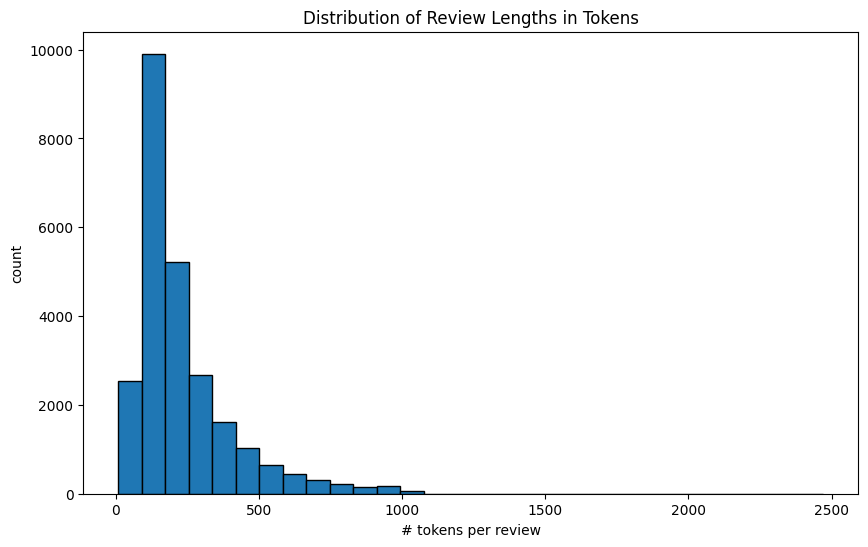

In [ ]:
review_lengths = [len(tokens) for tokens in train_tokens]

# Plot the histogram for review lengths
plt.figure(figsize=(10, 6))
plt.hist(review_lengths, bins=30, edgecolor='black')
plt.xlabel('# tokens per review')
plt.ylabel('count')
plt.title('Distribution of Review Lengths in Tokens')
plt.show()

In [6]:
num_steps = 500  # sequence length
train_features = torch.tensor([d2l.truncate_pad(
    vocab[line], num_steps, vocab['<pad>']) for line in train_tokens])
print(train_features.shape)

torch.Size([25000, 500])


In [ ]:
batch_size = 16
num_steps = 500

train_iter, test_iter, vocab = load_data_imdb(batch_size, num_steps)

print("Vocabulary size:", len(vocab))

for X, y in train_iter:
    print("Train batch X shape:", X.shape)
    print("Train batch y shape:", y.shape)
    break

for X, y in test_iter:
    print("Test batch X shape:", X.shape)
    print("Test batch y shape:", y.shape)
    break

print("Train batches:", len(train_iter))
print("Test batches:", len(test_iter))

Vocabulary size: 49347
Train batch X shape: torch.Size([16, 500])
Train batch y shape: torch.Size([16])
Test batch X shape: torch.Size([16, 500])
Test batch y shape: torch.Size([16])
Train batches: 1563
Test batches: 1563


In [8]:
vocab_size = len(vocab)
embed_dim = 100
hidden_dim = 64
output_dim = 2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = CRNN(
    vocab_size=len(vocab),
    embed_dim=100,
    hidden_dim=64,
    output_dim=2,
    pretrained_embeddings=None,
    freeze_embeddings=True,
    dropout_prob=0.1
).to(device)
print(model)

CRNN(
  (embedding): Embedding(49347, 100)
  (embedding_dropout): Dropout(p=0.1, inplace=False)
  (conv): Conv1d(100, 64, kernel_size=(5,), stride=(1,), padding=(2,))
  (conv_dropout): Dropout(p=0.1, inplace=False)
  (gru): GRU(64, 64, batch_first=True)
  (gru_dropout): Dropout(p=0.1, inplace=False)
  (fc): Linear(in_features=64, out_features=2, bias=True)
)


In [ ]:
from d2l import torch as d2l
import os

# i added this section because i had issues w the reading of glove embedding, can remove if no issues
class CustomTokenEmbedding(d2l.TokenEmbedding):
    def _load_embedding(self, embedding_name):
        idx_to_token, idx_to_vec = ['<unk>'], []
        data_dir = d2l.download_extract(embedding_name)
        with open(os.path.join(data_dir, 'vec.txt'), 'r', encoding='utf-8') as f:
            for line in f:
                elems = line.rstrip().split(' ')
                token, elems = elems[0], [float(elem) for elem in elems[1:]]
                idx_to_token.append(token)
                idx_to_vec.append(elems)
        idx_to_vec = [[0.0] * len(idx_to_vec[0])] + idx_to_vec
        return idx_to_token, torch.tensor(idx_to_vec)

glove_embedding = CustomTokenEmbedding('glove.6b.100d')
embeds = glove_embedding[vocab.idx_to_token]
model.embedding.weight.data.copy_(embeds)
model.embedding.weight.requires_grad = False

In [10]:
print(f"GloVe Embedding Shape: {embeds.shape}")
print(f"Embedding Weight Shape: {model.embedding.weight.data.shape}")

GloVe Embedding Shape: torch.Size([49347, 100])
Embedding Weight Shape: torch.Size([49347, 100])


('model', 'train_iter', 'test_iter', 'optimizer', 'criterion', 'device', 'num_epochs', 'save_dir', 'train_losses', 'train_accuracies', 'test_accuracies', 'best_acc', 'epoch', 'epoch_loss', 'correct', 'total', 'X', 'y', 'outputs', 'loss', 'preds', 'avg_loss', 'train_acc', 'y_hat', '_', 'predicted', 'test_acc', 'checkpoint_path', 'best_checkpoint_path')
Epoch 1, Loss: 0.6933, Train Acc: 0.506, Test Acc: 0.495
Best model checkpoint saved: checkpoints\crnn_best_model.pt
Epoch 2, Loss: 0.6918, Train Acc: 0.508, Test Acc: 0.501
Best model checkpoint saved: checkpoints\crnn_best_model.pt
Epoch 3, Loss: 0.6905, Train Acc: 0.511, Test Acc: 0.508
Best model checkpoint saved: checkpoints\crnn_best_model.pt
Epoch 4, Loss: 0.6876, Train Acc: 0.513, Test Acc: 0.510
Best model checkpoint saved: checkpoints\crnn_best_model.pt
Epoch 5, Loss: 0.6812, Train Acc: 0.520, Test Acc: 0.520
Best model checkpoint saved: checkpoints\crnn_best_model.pt
Epoch 6, Loss: 0.6446, Train Acc: 0.598, Test Acc: 0.702
Best

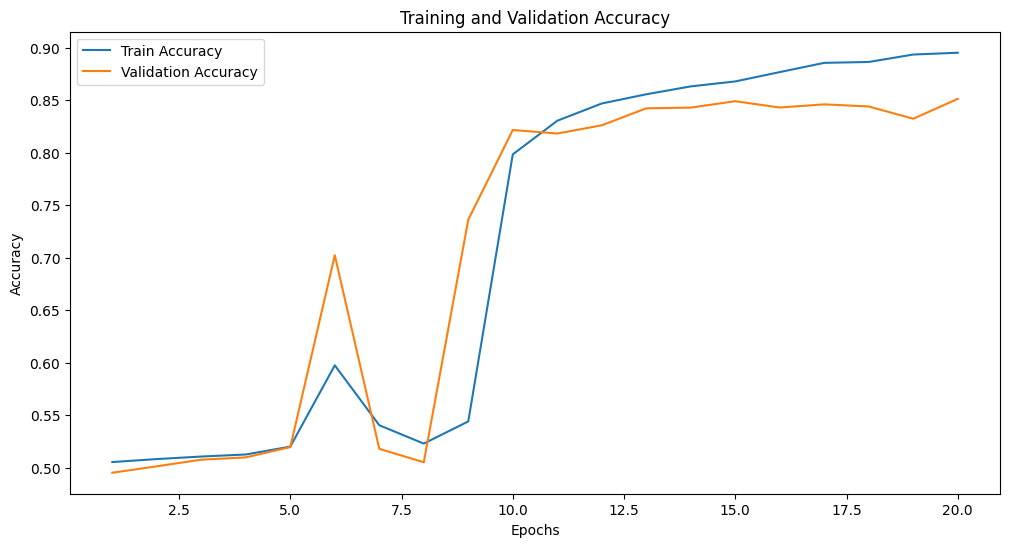

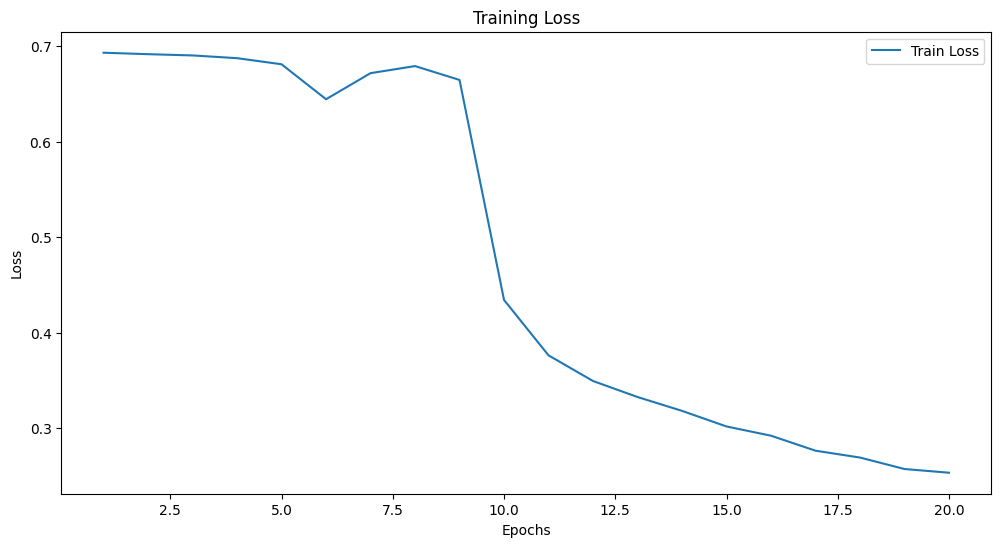

In [11]:
# Train
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
num_epochs = 20

print(train_model.__code__.co_varnames)

train_losses, train_accuracies, test_accuracies = train_model(
    model=model,
    train_iter=train_iter,
    test_iter=test_iter,
    optimizer=optimizer,
    criterion=criterion,
    device=device,
    num_epochs=num_epochs,
    save_dir="checkpoints"
)

# Plot metrics
import matplotlib.pyplot as plt

epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 6))
plt.plot(epochs, train_accuracies, label="Train Accuracy")
plt.plot(epochs, test_accuracies, label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(epochs, train_losses, label="Train Loss")
plt.title("Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [12]:
# Eval on test set
precision, recall, f1, accuracy = evaluate_model(model, test_iter, device)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Accuracy: {accuracy:.4f}")

Precision: 0.8520
Recall: 0.8512
F1 Score: 0.8512
Accuracy: 0.8512
